In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [99]:
claims = pd.read_csv('claims.csv')
claims.head()

,member_id,employer_name,claim_id,line_number,benefit_category,major_clinical_condition,minor_clinical_condition,claim_status,claim_grouping_major,claim_grouping_minor,is_in_network,service_month,allowed_amount,paid_amount
0,108297829,Donald Duck Co.,71162567-108297829,1,PHY_PCP_OV,Respiratory conditions,Other upper respiratory disease,FINALIZED,Professional,Office Visit - Primary Care,Yes,2020-01,230.00,215.00
1,115098509,Donald Duck Co.,73362567-115098509,1,PHY_PT,Musculoskeletal disease,Non-traumatic joint disorders,FINALIZED,Professional,Rehabilitation,Yes,2020-01,34.61,19.61
2,115098509,Donald Duck Co.,73362567-115098509,2,PHY_PT,Musculoskeletal disease,Non-traumatic joint disorders,FINALIZED,Professional,Rehabilitation,Yes,2020-01,27.64,27.64
3,115098509,Donald Duck Co.,73362567-115098509,3,PHY_PT,Musculoskeletal disease,Non-traumatic joint disorders,FINALIZED,Professional,Rehabilitation,Yes,2020-01,29.42,29.42
4,167996799,Donald Duck Co.,73412517-167996799,2,PHY_PCP_OV,Respiratory conditions,Respiratory infections,FINALIZED,Professional,Office Visit - Primary Care,Yes,2020-01,53.72,38.72


In [100]:
# fix employers' name typo
claims['employer_name'] = claims.employer_name.str.replace('Mickey Inc.', 'Mickey Mouse Inc.')
claims['employer_name'] = claims.employer_name.str.replace('Donald Co.', 'Donald Duck Co.')

# remove duplicates
print('raw claims:', claims.shape)
claims = claims.drop_duplicates()
print('removed duplicated claims:', claims.shape)

raw claims: (21843, 14)
removed duplicated claims: (21842, 14)


In [101]:
mem = pd.read_csv('membership.csv')
mem.head()

,member_id,employer_name,gender,effective_month,coverage_tier,relationship_medical,plan_type,plan_name
0,105070503,Mickey Mouse Inc.,F,2020-04,Employee Only,subscriber,Medical,PPO
1,226038609,Mickey Mouse Inc.,M,2020-04,Employee + Family,subscriber,Medical,PPO
2,338932895,Mickey Mouse Inc.,M,2020-04,Employee + Family,subscriber,Medical,PPO
3,280835088,Mickey Mouse Inc.,M,2020-04,Employee + Spouse,subscriber,Medical,PPO
4,172970293,Mickey Mouse Inc.,M,2020-04,Employee Only,subscriber,Medical,PPO


### Question:

How many subscribers were effective on the PPO medical plan for each month for Donald
Duck Co.?

In [102]:
temp = mem.query('employer_name == "Donald Duck Co." and plan_name == "PPO"')
temp['effective_month'] = pd.to_datetime(temp.effective_month)
q1 = temp.groupby('effective_month').member_id.nunique()
print(q1)

effective_month
2020-01-01    2408
2020-02-01    2413
2020-03-01    2414
2020-04-01    2376
Name: member_id, dtype: int64


### Question:

What is the distribution of claim dollars (employer-paid basis) across various coverage
tiers?

                             paid_amount
member_id coverage_tier                 
100097009 Employee + Spouse         0.00
100098009 Employee + Family      4252.08
100099009 Employee + Spouse      1020.00
100197019 Employee + Spouse       774.52
100198019 Employee + Family      3645.84


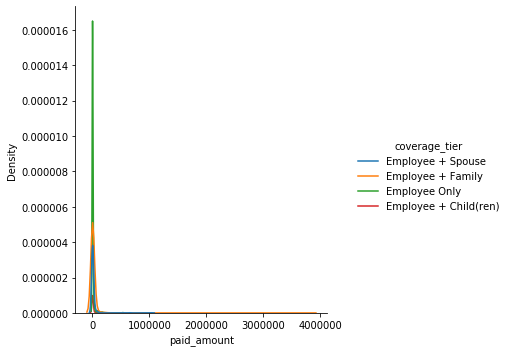

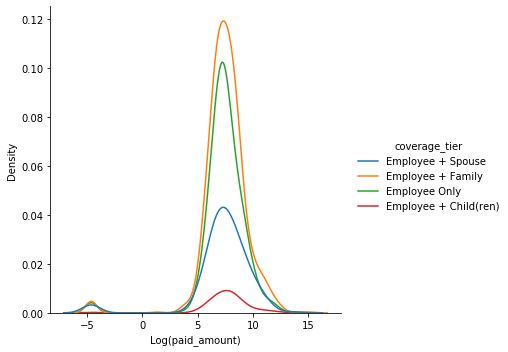

In [103]:
temp = pd.merge(claims[['member_id', 'employer_name', 'paid_amount']],
              mem[['member_id', 'employer_name', 'coverage_tier']],
              left_on = ['member_id', 'employer_name'], right_on = ['member_id', 'employer_name'])

q2 = temp.groupby(['member_id', 'coverage_tier'])[['paid_amount']].agg('sum')
print(q2.head())

sns.displot(x='paid_amount', hue='coverage_tier', kind='kde', data=q2)
q2['Log(paid_amount)'] = np.log(q2.paid_amount+0.01)
sns.displot(x='Log(paid_amount)', hue='coverage_tier', kind='kde', data=q2)
plt.show()

### Question

Compare the allowed PMPM (per member per month) due to respiratory conditions
between the two employer groups.

In [104]:
q3 = claims.query('major_clinical_condition == "Respiratory conditions"').groupby(['employer_name', 'service_month']).agg({'allowed_amount': np.sum, 'member_id': pd.Series.nunique})
q3.eval('Allowed_PMPM = allowed_amount/member_id', inplace=True)
print(q3)

                                 allowed_amount  member_id  Allowed_PMPM
employer_name     service_month                                         
Donald Duck Co.   2020-01              33926.30        124    273.599194
                  2020-02              59725.63         97    615.728144
                  2020-03              33695.59         86    391.809186
                  2020-04              55933.81         90    621.486778
Mickey Mouse Inc. 2020-01              31226.25         62    503.649194
                  2020-02              23259.99         65    357.846000
                  2020-03              17507.24         68    257.459412
                  2020-04              27025.34         48    563.027917


### Question

Are the claim paid amounts statistically significantly different between the two
companies? For simplicity, you may assume that paid claims fit a normal distribution

In [105]:
from scipy.stats import ttest_ind, levene

x = claims.query('employer_name == "Donald Duck Co."').paid_amount
y = claims.query('employer_name == "Mickey Mouse Inc."').paid_amount

print('Independent T-test:')
print(ttest_ind(x, y))

Independent T-test:
Ttest_indResult(statistic=1.3787310080476685, pvalue=0.16799182612607602)


As assuming paid claims fit a normal distribution, I applied an `indepentent T-test` to test for a statistically significant difference of claim paid amounts between two companies (Donald Duck Co. vs Mickey Mouse Inc.). The null hypothesis is that two independent samples have identical average values. **The result shows p-value = 0.168 > 0.05, so there is a statistically significant difference in the average of claim paid amounts between two companies.**

In [106]:
print("Levene's test:")
print(levene(x, y, center= 'mean'))

Levene's test:
LeveneResult(statistic=6.186057298991946, pvalue=0.012883480651485844)


However, one of the assumptions needs to be checked that both groups have equal variances. One method for testing this assumption is the `Levene's test` of homogeneity of variances. The null hypothesis that all input samples are from populations with equal variances. **The result of Levene's test shows p-value = 0.01 < 0.05, so the two distributions of claim paid amounts have non-equal variance.**

In [107]:
print('Welch’s t-test:')
print(ttest_ind(x, y, equal_var=False))

Welch’s t-test:
Ttest_indResult(statistic=1.7900104845550546, pvalue=0.07346883847983107)


Therefore, I applied the `Welch’s t-test`, which does not assume equal population variance. **The result of Welch’s t-test shows p-value = 0.07 > 0.05, so it also concludes the claim paid amounts are significant different between two companies.**

### Question

We want to identify the drivers of medical costs by analyzing the total allowed amount accrued per member for both employer groups.

a. Who are the top 5 large claimants (based on the total allowed amount) for Donald Duck Co. across the entire time captured in the data? Your response should include member ID, gender, relationship, and the total allowed amount.

In [108]:
temp = claims.groupby(['member_id', 'employer_name']).agg({'allowed_amount': np.sum}).reset_index()
temp = temp.groupby('employer_name')[['member_id', 'allowed_amount']].apply(lambda x: x.sort_values('allowed_amount', ascending=False))
temp = temp.groupby('employer_name').head(5).member_id

q5 = pd.merge(mem, temp,
              left_on = ['member_id'],
              right_on = ['member_id'],
              how='inner')[['member_id', 'gender', 'relationship_medical']].drop_duplicates()

q5

,member_id,gender,relationship_medical
0,192169219,F,child
4,215959599,F,subscriber
8,159170913,F,subscriber
12,103398339,F,spouse
16,145498549,F,subscriber
20,396924697,M,child
24,191698169,M,subscriber
28,135498549,M,subscriber
32,137870783,F,spouse
36,200345038,F,subscriber


b. We want to identify the drivers of the total allowed amount per claimant over the
entire period. Please run a multivariate OLS regression with the total allowed dollars across all claims per member (same methodology as 5a above beforefiltering for top 5 claimants) as the dependent variable and major clinical condition and employer as the independent variables. What is the goodness of fit for this
model? Assuming there is an omitted variable bias, how would you improve the model?

In [109]:
temp = claims.groupby(['member_id', 'employer_name', 'major_clinical_condition']).agg({'allowed_amount': np.sum}).reset_index()

q5 = pd.merge(mem, temp,
              left_on = ['member_id'],
              right_on = ['member_id'],
              how='inner')[['member_id', 'gender', 'coverage_tier', 'relationship_medical', 'major_clinical_condition', 'allowed_amount']].drop_duplicates()

q5.head()

,member_id,gender,coverage_tier,relationship_medical,major_clinical_condition,allowed_amount
0,172970293,M,Employee Only,subscriber,Musculoskeletal disease,783.61
4,239031904,F,Employee + Family,child,General evaluation and undiagnosed symptoms,1136.29
5,239031904,F,Employee + Family,child,Skin and subcutaneous tissue disorders,257.76
12,114497449,F,Employee + Family,spouse,"Injury, burns, and poisoning",152.00
13,114497449,F,Employee + Family,spouse,Nervous system diseases,983.02


In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = q5[['gender', 'coverage_tier', 'relationship_medical', 'major_clinical_condition']]
y = q5.allowed_amount

# create dummies variables instead of one-hot-encoding due to multicollinearity issue
X_trans = pd.get_dummies(X, drop_first=True)

model = LinearRegression()
model.fit(X_trans, y)
y_pred = model.predict(X_trans)
r2 = r2_score(y, y_pred)
print('Goodness of fit for this OLS regression:', round(r2,3))

Goodness of fit for this OLS regression: 0.036


Because the R-squared score of OLS regression is quite low, 0.036, we might conclude that the total claim allowed does not have a strong linear relationship between those features, which is the baseline assumption of multivariate OLS regression. For the improvement, I suggest fitting a tree-base model to extract non-linear patterns on the high dimensional space. For example, the Random Forests Model can easily learn interaction features and non-linear relationship between allowed claim costs, and provides the feature importance to answer the data-driven factors of medical costs.

### Question

List and describe any data issues you found along with assumptions/fixes you had to
make to answer the above questions.

Answer:
1. `employer name` in the claim table has different formats for two companies.
2. One duplicated claim (16420021-145498549) has been found.
3. There are 1% claims that total allowed is greater than \$3244.50, called high-cost claimants. We might need to further verify the data quality.
4. There are 3,119 claim records with \$0 allowed amount and major clinical conditions. We need to verify the raw data quality.

Top 1% allowed cost claims: 3244.501999999985


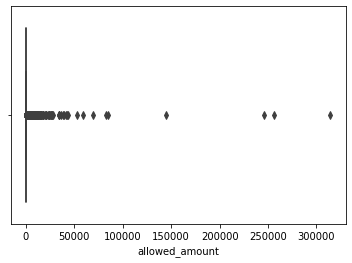

In [93]:
print('Top 1% allowed cost claims:', np.percentile(claims.allowed_amount, 99))

sns.boxplot(claims.allowed_amount)
plt.show()

In [126]:
claims[claims.allowed_amount == 0].head()

,member_id,employer_name,claim_id,line_number,benefit_category,major_clinical_condition,minor_clinical_condition,claim_status,claim_grouping_major,claim_grouping_minor,is_in_network,service_month,allowed_amount,paid_amount
23,117198719,Donald Duck Co.,76973177-117198719,2,HIP_RoomBoard,Maternity and complications related to childbirth,Complications mainly related to pregnancy,FINALIZED,Inpatient Facility,Medical,Yes,2020-01,0.0,0.0
24,117198719,Donald Duck Co.,76973177-117198719,3,HIP_RoomBoard,Maternity and complications related to childbirth,Complications mainly related to pregnancy,FINALIZED,Inpatient Facility,Medical,Yes,2020-01,0.0,0.0
25,117198719,Donald Duck Co.,76973177-117198719,4,HIP_RoomBoard,Maternity and complications related to childbirth,Complications mainly related to pregnancy,FINALIZED,Inpatient Facility,Medical,Yes,2020-01,0.0,0.0
26,117198719,Donald Duck Co.,76973177-117198719,5,HIP_RoomBoard,Maternity and complications related to childbirth,Complications mainly related to pregnancy,FINALIZED,Inpatient Facility,Medical,Yes,2020-01,0.0,0.0
27,117198719,Donald Duck Co.,76973177-117198719,6,HIP_RoomBoard,Maternity and complications related to childbirth,Complications mainly related to pregnancy,FINALIZED,Inpatient Facility,Medical,Yes,2020-01,0.0,0.0
